In [ ]:
import os
import sys
from dotenv import load_dotenv
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from tqdm import tqdm
from torchinfo import summary

load_dotenv()

sys.path.append(os.path.abspath(os.path.join("../..")))
from src.datasets.huggingfacedataset import HuggingFaceDataset  # noqa: E402
from src.models.crnn.crnn_v1 import Captcha_CRNN_V1

In [ ]:
captcha_transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((40, 150)),
        transforms.RandomInvert(p=0.5),
        transforms.ToTensor(),
    ]
)
dataset = HuggingFaceDataset(
    root_dir="/nfs/home/tpz8688/Captcha-Recognition/data/hammer_captchas", 
    transform=captcha_transformation, 
    preload=True
)

Caching 1365874 images to RAM...


100%|██████████| 1365874/1365874 [41:18<00:00, 551.07it/s] 


In [38]:
# import numpy as np

# # Convert cached_images to tensors
# cached_images_tensor = [torch.tensor(np.array(img)) for img in dataset.cached_images]

# # Save everything
# torch.save({
#     "images": cached_images_tensor,
#     "labels": dataset.cached_labels
# }, "preprocessed_hf_dataset.pt")

In [4]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_size, val_size, test_size

(1092699, 136587, 136588)

In [5]:
def captcha_collate_fn(batch):
    """
    batch is a list of tuples: [(image, label, length), ...]
    """
    images, labels, lengths = zip(*batch)
    
    # Stack images into [Batch, Channels, H, W]
    images = torch.stack(images, 0)
    
    # Pad labels into [Batch, Max_Label_Len_In_Batch]
    # padding_value=0 is the 'blank' index
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)
    
    # Convert lengths to a tensor
    label_lengths = torch.tensor(lengths, dtype=torch.long)
    
    return images, labels_padded, label_lengths

In [6]:
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=captcha_collate_fn, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=captcha_collate_fn, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=captcha_collate_fn)

In [7]:
model = Captcha_CRNN_V1(num_chars=len(dataset.vocab) + 1)  # Add Blank Character to Vocabulary
summary(model, input_size=(1, 1, 40, 150))

Layer (type:depth-idx)                   Output Shape              Param #
Captcha_CRNN_V1                          [1, 37, 63]               --
├─Sequential: 1-1                        [1, 256, 5, 37]           --
│    └─Conv2d: 2-1                       [1, 32, 40, 150]          320
│    └─BatchNorm2d: 2-2                  [1, 32, 40, 150]          64
│    └─SiLU: 2-3                         [1, 32, 40, 150]          --
│    └─MaxPool2d: 2-4                    [1, 32, 20, 75]           --
│    └─Conv2d: 2-5                       [1, 64, 20, 75]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 20, 75]           128
│    └─SiLU: 2-7                         [1, 64, 20, 75]           --
│    └─MaxPool2d: 2-8                    [1, 64, 10, 37]           --
│    └─Conv2d: 2-9                       [1, 128, 10, 37]          73,856
│    └─BatchNorm2d: 2-10                 [1, 128, 10, 37]          256
│    └─SiLU: 2-11                        [1, 128, 10, 37]          --
│   

In [8]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    # 1. Unpack images, labels, AND lengths
    for images, labels, lengths in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)
        # lengths stays as a CPU tensor (CTCLoss prefers it there)

        optimizer.zero_grad()

        # Forward pass
        logits = model(images) # [Batch, Time, Vocab]

        # Prepare for CTC (Log Softmax + Permute)
        # log_probs shape: [Time, Batch, Vocab]
        log_probs = torch.nn.functional.log_softmax(logits, dim=2).permute(1, 0, 2)

        # 2. Input lengths: The number of time steps (37)
        batch_size = images.size(0)
        input_lengths = torch.full(
            (batch_size,), log_probs.size(0), dtype=torch.long
        )

        # 3. Target lengths: Use the ACTUAL lengths from the dataset/collate_fn
        target_lengths = lengths 

        # Calculate Loss
        loss = criterion(log_probs, labels, input_lengths, target_lengths)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [9]:
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        # 1. Unpack images, labels, and the actual label lengths
        for images, labels, lengths in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images) # [Batch, Time, Vocab]

            # 2. Prepare for CTC (Log Softmax + Permute)
            # log_probs shape: [Time, Batch, Vocab]
            log_probs = torch.nn.functional.log_softmax(logits, dim=2).permute(1, 0, 2)

            # 3. Input lengths: The number of time steps (usually 37)
            batch_size = images.size(0)
            input_lengths = torch.full(
                (batch_size,), log_probs.size(0), dtype=torch.long
            )

            # 4. Target lengths: Use the ACTUAL lengths provided by the loader
            target_lengths = lengths 

            # Calculate Loss
            loss = criterion(log_probs, labels, input_lengths, target_lengths)
            val_loss += loss.item()

    return val_loss / len(dataloader)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 1. Define the Criterion outside the loop
# blank=0 matches your dataset's self.idx_to_char[0] = ""
criterion = nn.CTCLoss(blank=0, zero_infinity=True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=3,
)

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # 2. Pass 'criterion' into both functions
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"LR: {current_lr:.6f} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Ensure the directory exists before saving
        model.SAVE_DIR.mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), model.SAVE_DIR / "v2.pth")
        print(f"--> New best model saved (Val Loss: {best_val_loss:.4f})")
    
    print("-" * 30)

Training:   0%|          | 0/8537 [00:00<?, ?it/s]

Training: 100%|██████████| 8537/8537 [04:10<00:00, 34.03it/s]


Epoch 1/50
LR: 0.002000 | Train Loss: 0.6092 | Val Loss: 0.3044
--> New best model saved (Val Loss: 0.3044)
------------------------------


Training: 100%|██████████| 8537/8537 [04:01<00:00, 35.40it/s]


Epoch 2/50
LR: 0.002000 | Train Loss: 0.2684 | Val Loss: 0.2591
--> New best model saved (Val Loss: 0.2591)
------------------------------


Training: 100%|██████████| 8537/8537 [04:03<00:00, 35.11it/s]


Epoch 3/50
LR: 0.002000 | Train Loss: 0.2434 | Val Loss: 0.2491
--> New best model saved (Val Loss: 0.2491)
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.86it/s]


Epoch 4/50
LR: 0.002000 | Train Loss: 0.2360 | Val Loss: 0.2442
--> New best model saved (Val Loss: 0.2442)
------------------------------


Training: 100%|██████████| 8537/8537 [04:02<00:00, 35.15it/s]


Epoch 5/50
LR: 0.002000 | Train Loss: 0.2310 | Val Loss: 0.2436
--> New best model saved (Val Loss: 0.2436)
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.98it/s]


Epoch 6/50
LR: 0.002000 | Train Loss: 0.2258 | Val Loss: 0.2434
--> New best model saved (Val Loss: 0.2434)
------------------------------


Training: 100%|██████████| 8537/8537 [04:03<00:00, 34.99it/s]


Epoch 7/50
LR: 0.002000 | Train Loss: 0.2236 | Val Loss: 0.2410
--> New best model saved (Val Loss: 0.2410)
------------------------------


Training: 100%|██████████| 8537/8537 [04:00<00:00, 35.49it/s]


Epoch 8/50
LR: 0.002000 | Train Loss: 0.2216 | Val Loss: 0.2429
------------------------------


Training: 100%|██████████| 8537/8537 [04:07<00:00, 34.44it/s]


Epoch 9/50
LR: 0.002000 | Train Loss: 0.2212 | Val Loss: 0.2603
------------------------------


Training: 100%|██████████| 8537/8537 [04:01<00:00, 35.32it/s]


Epoch 10/50
LR: 0.002000 | Train Loss: 0.2206 | Val Loss: 0.2376
--> New best model saved (Val Loss: 0.2376)
------------------------------


Training: 100%|██████████| 8537/8537 [04:10<00:00, 34.13it/s]


Epoch 11/50
LR: 0.002000 | Train Loss: 0.2266 | Val Loss: 0.2542
------------------------------


Training: 100%|██████████| 8537/8537 [04:05<00:00, 34.78it/s]


Epoch 12/50
LR: 0.002000 | Train Loss: 0.2211 | Val Loss: 0.2374
--> New best model saved (Val Loss: 0.2374)
------------------------------


Training: 100%|██████████| 8537/8537 [04:07<00:00, 34.46it/s]


Epoch 13/50
LR: 0.002000 | Train Loss: 0.2289 | Val Loss: 0.2538
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.93it/s]


Epoch 14/50
LR: 0.002000 | Train Loss: 0.2293 | Val Loss: 0.2546
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.97it/s]


Epoch 15/50
LR: 0.002000 | Train Loss: 0.2252 | Val Loss: 0.2497
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.96it/s]


Epoch 16/50
LR: 0.001000 | Train Loss: 0.2280 | Val Loss: 0.2403
------------------------------


Training: 100%|██████████| 8537/8537 [04:03<00:00, 35.00it/s]


Epoch 17/50
LR: 0.001000 | Train Loss: 0.2049 | Val Loss: 0.2303
--> New best model saved (Val Loss: 0.2303)
------------------------------


Training: 100%|██████████| 8537/8537 [04:03<00:00, 35.12it/s]


Epoch 18/50
LR: 0.001000 | Train Loss: 0.2003 | Val Loss: 0.2301
--> New best model saved (Val Loss: 0.2301)
------------------------------


Training: 100%|██████████| 8537/8537 [04:06<00:00, 34.61it/s]


Epoch 19/50
LR: 0.001000 | Train Loss: 0.1979 | Val Loss: 0.2286
--> New best model saved (Val Loss: 0.2286)
------------------------------


Training: 100%|██████████| 8537/8537 [04:09<00:00, 34.21it/s]


Epoch 20/50
LR: 0.001000 | Train Loss: 0.1961 | Val Loss: 0.2302
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.85it/s]


Epoch 21/50
LR: 0.001000 | Train Loss: 0.1947 | Val Loss: 0.2320
------------------------------


Training: 100%|██████████| 8537/8537 [04:10<00:00, 34.07it/s]


Epoch 22/50
LR: 0.001000 | Train Loss: 0.1936 | Val Loss: 0.2310
------------------------------


Training: 100%|██████████| 8537/8537 [04:08<00:00, 34.40it/s]


Epoch 23/50
LR: 0.000500 | Train Loss: 0.1927 | Val Loss: 0.2321
------------------------------


Training: 100%|██████████| 8537/8537 [04:15<00:00, 33.36it/s]


Epoch 24/50
LR: 0.000500 | Train Loss: 0.1875 | Val Loss: 0.2304
------------------------------


Training: 100%|██████████| 8537/8537 [04:03<00:00, 35.10it/s]


Epoch 25/50
LR: 0.000500 | Train Loss: 0.1851 | Val Loss: 0.2305
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.87it/s]


Epoch 26/50
LR: 0.000500 | Train Loss: 0.1838 | Val Loss: 0.2323
------------------------------


Training: 100%|██████████| 8537/8537 [04:06<00:00, 34.62it/s]


Epoch 27/50
LR: 0.000250 | Train Loss: 0.1828 | Val Loss: 0.2336
------------------------------


Training: 100%|██████████| 8537/8537 [04:01<00:00, 35.38it/s]


Epoch 28/50
LR: 0.000250 | Train Loss: 0.1806 | Val Loss: 0.2332
------------------------------


Training: 100%|██████████| 8537/8537 [03:56<00:00, 36.02it/s]


Epoch 29/50
LR: 0.000250 | Train Loss: 0.1795 | Val Loss: 0.2335
------------------------------


Training: 100%|██████████| 8537/8537 [04:03<00:00, 35.13it/s]


Epoch 30/50
LR: 0.000250 | Train Loss: 0.1788 | Val Loss: 0.2354
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.85it/s]


Epoch 31/50
LR: 0.000125 | Train Loss: 0.1783 | Val Loss: 0.2359
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.87it/s]


Epoch 32/50
LR: 0.000125 | Train Loss: 0.1774 | Val Loss: 0.2363
------------------------------


Training: 100%|██████████| 8537/8537 [04:08<00:00, 34.38it/s]


Epoch 33/50
LR: 0.000125 | Train Loss: 0.1770 | Val Loss: 0.2373
------------------------------


Training: 100%|██████████| 8537/8537 [04:00<00:00, 35.56it/s]


Epoch 34/50
LR: 0.000125 | Train Loss: 0.1767 | Val Loss: 0.2379
------------------------------


Training: 100%|██████████| 8537/8537 [04:05<00:00, 34.74it/s]


Epoch 35/50
LR: 0.000063 | Train Loss: 0.1765 | Val Loss: 0.2377
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.89it/s]


Epoch 36/50
LR: 0.000063 | Train Loss: 0.1761 | Val Loss: 0.2389
------------------------------


Training: 100%|██████████| 8537/8537 [04:02<00:00, 35.23it/s]


Epoch 37/50
LR: 0.000063 | Train Loss: 0.1760 | Val Loss: 0.2387
------------------------------


Training: 100%|██████████| 8537/8537 [04:07<00:00, 34.51it/s]


Epoch 38/50
LR: 0.000063 | Train Loss: 0.1759 | Val Loss: 0.2394
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.95it/s]


Epoch 39/50
LR: 0.000031 | Train Loss: 0.1758 | Val Loss: 0.2399
------------------------------


Training: 100%|██████████| 8537/8537 [04:01<00:00, 35.28it/s]


Epoch 40/50
LR: 0.000031 | Train Loss: 0.1756 | Val Loss: 0.2403
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.91it/s]


Epoch 41/50
LR: 0.000031 | Train Loss: 0.1756 | Val Loss: 0.2405
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.96it/s]


Epoch 42/50
LR: 0.000031 | Train Loss: 0.1755 | Val Loss: 0.2405
------------------------------


Training: 100%|██████████| 8537/8537 [04:08<00:00, 34.31it/s]


Epoch 43/50
LR: 0.000016 | Train Loss: 0.1755 | Val Loss: 0.2407
------------------------------


Training: 100%|██████████| 8537/8537 [04:05<00:00, 34.75it/s]


Epoch 44/50
LR: 0.000016 | Train Loss: 0.1754 | Val Loss: 0.2408
------------------------------


Training: 100%|██████████| 8537/8537 [04:07<00:00, 34.55it/s]


Epoch 45/50
LR: 0.000016 | Train Loss: 0.1754 | Val Loss: 0.2409
------------------------------


Training: 100%|██████████| 8537/8537 [04:03<00:00, 35.06it/s]


Epoch 46/50
LR: 0.000016 | Train Loss: 0.1753 | Val Loss: 0.2407
------------------------------


Training: 100%|██████████| 8537/8537 [04:07<00:00, 34.53it/s]


Epoch 47/50
LR: 0.000008 | Train Loss: 0.1753 | Val Loss: 0.2411
------------------------------


Training: 100%|██████████| 8537/8537 [04:01<00:00, 35.32it/s]


Epoch 48/50
LR: 0.000008 | Train Loss: 0.1753 | Val Loss: 0.2414
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.94it/s]


Epoch 49/50
LR: 0.000008 | Train Loss: 0.1753 | Val Loss: 0.2410
------------------------------


Training: 100%|██████████| 8537/8537 [04:04<00:00, 34.98it/s]


Epoch 50/50
LR: 0.000008 | Train Loss: 0.1753 | Val Loss: 0.2413
------------------------------


In [11]:
model = Captcha_CRNN_V1(num_chars=len(dataset.vocab) + 1)
state_dict = torch.load(Captcha_CRNN_V1.SAVE_DIR / "v2.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval() 

print(f"Model successfully loaded from {Captcha_CRNN_V1.SAVE_DIR / "v2.pth"}")


Model successfully loaded from /nfs/home/tpz8688/Captcha-Recognition/weights/crnn/v2.pth


In [12]:
def decode_predictions(logits, dataset):
    # logits shape: (Time_Steps, Num_Chars)
    # Get the index of the highest probability for each time step
    tokens = torch.argmax(logits, dim=-1)  # Shape: (Time_Steps)

    char_list = []
    for i in range(len(tokens)):
        token = tokens[i].item()

        # CTC Rules:
        # 1. Skip the blank token (index 0)
        # 2. Skip repeated tokens (if the model predicts 'aaaa', it's just 'a')
        if token != 0:
            if i > 0 and tokens[i] == tokens[i - 1]:
                continue
            char_list.append(dataset.idx_to_char[token])

    return "".join(char_list)

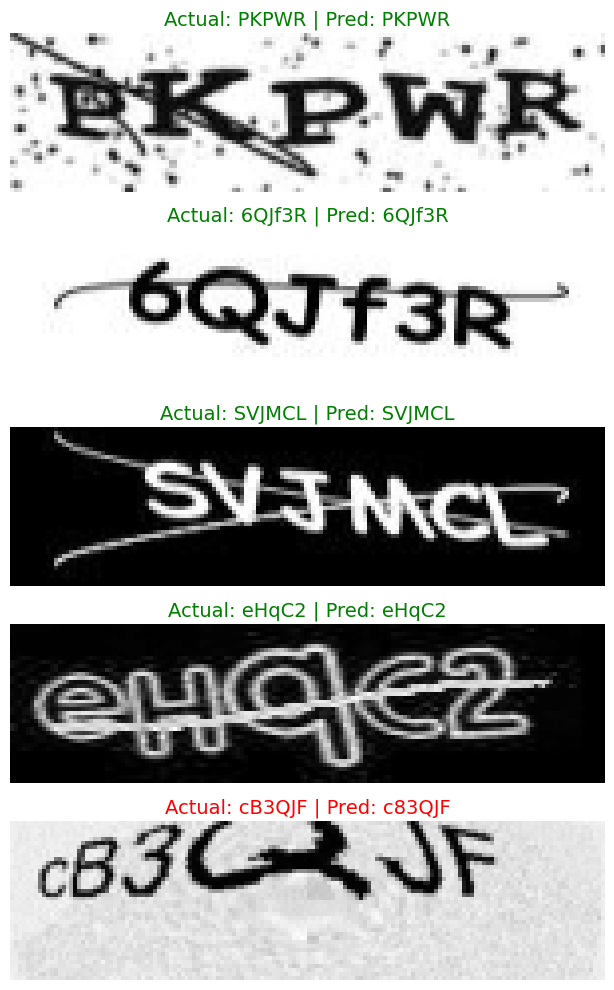

In [36]:
import matplotlib.pyplot as plt
import random


def visualize_predictions(model, dataloader, dataset, device, num_samples=5):
    model.eval()

    # 1. Get just ONE batch without loading the whole dataset
    # We use a loop that breaks immediately to grab the 'first' available batch
    # If your test_loader has shuffle=True, this will be a random batch.
    images, labels, _ = next(iter(dataloader))

    images = images.to(device)
    with torch.no_grad():
        logits = model(images)

    plt.figure(figsize=(15, 10))

    batch_size = images.size(0)
    # Pick random indices within this single batch
    indices = random.sample(range(batch_size), min(num_samples, batch_size))

    for i, idx in enumerate(indices):
        img = images[idx].cpu().squeeze().numpy()
        pred_str = decode_predictions(logits[idx], dataset)
        actual_indices = [val.item() for val in labels[idx] if val.item() != 0]
        actual_str = "".join([dataset.idx_to_char[val] for val in actual_indices])

        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img, cmap="gray")
        color = "green" if pred_str == actual_str else "red"
        plt.title(f"Actual: {actual_str} | Pred: {pred_str}", color=color, fontsize=14)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Usage:
visualize_predictions(model, test_loader, dataset, device)

In [17]:
import Levenshtein

def run_evaluation(model, dataloader, dataset, device):
    model.eval()
    
    total_samples = 0
    perfect_matches = 0
    
    total_edit_distance = 0
    total_actual_chars = 0

    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            logits = model(images) # [Batch, Time, Vocab]
            
            for i in range(images.size(0)):
                # 1. Decode prediction and actual label
                pred_str = decode_predictions(logits[i], dataset)
                
                actual_indices = [val.item() for val in labels[i] if val.item() != 0]
                actual_str = "".join([dataset.idx_to_char[val] for val in actual_indices])
                
                # 2. Update Word Accuracy Stats
                if pred_str == actual_str:
                    perfect_matches += 1
                total_samples += 1
                
                # 3. Update Character Accuracy Stats (Levenshtein)
                distance = Levenshtein.distance(pred_str, actual_str)
                total_edit_distance += distance
                total_actual_chars += len(actual_str)

    # Final Calculations
    word_accuracy = (perfect_matches / total_samples) * 100
    
    # Character Error Rate (CER) is distance/total_chars
    # Character Accuracy is 100 - CER
    cer = (total_edit_distance / total_actual_chars) * 100
    char_accuracy = 100 - cer

    print(f"\n" + "="*30)
    print(f"WORD ACCURACY: {word_accuracy:.2f}%")
    print(f"CHAR ACCURACY: {char_accuracy:.2f}%")
    print(f"TOTAL SAMPLES: {total_samples}")
    print("="*30)

    return word_accuracy, char_accuracy

In [18]:
run_evaluation(model, test_loader, test_dataset.dataset, device)

Evaluating: 100%|██████████| 1068/1068 [02:19<00:00,  7.68it/s]


WORD ACCURACY: 89.53%
CHAR ACCURACY: 93.95%
TOTAL SAMPLES: 136588


(89.52543415234135, 93.9476163009139)

In [ ]:
test_indices = test_dataset.indices
test_paths = [str(dataset.image_paths[i]) for i in test_indices]

with open("test_file_list_crnn.txt", "w") as f:
    for path in test_paths:
        f.write(path + "\n")

print(f"Saved {len(test_paths)} pointers to test_file_list.txt")

Saved 136588 pointers to test_file_list.txt
